In [10]:
# imports
import pandas as pd
import krippendorff
import numpy as np
import sqlite3
import matplotlib.pyplot as plt

In [ ]:
# combine data

db_files = ['1.db', '2.db', '3.db', '4.db', '6.db']
excel_file = '5.xlsx'
csv_file = '7.csv'

dataframes = []

for db_file in db_files:
    annotator_id = int(db_file.split('.')[0])
    
    conn = sqlite3.connect(db_file)
    tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
    
    if tables.empty:
        print(f"No tables in {db_file}, skipping.")
        conn.close()
        continue
    
    table_name = tables['name'][0]
    df = pd.read_sql_query(f"SELECT * FROM '{table_name}';", conn)
    conn.close()
    
    if 'userId' in df.columns:
        df.drop(columns=['userId'], inplace=True)

    df['annotator_id'] = annotator_id = int(db_file.split('.')[0])
    
    dataframes.append(df)

excel_df = pd.read_excel(excel_file)
excel_df['annotator_id'] = 5

csv_df = pd.read_csv(csv_file)
csv_df['annotator_id'] = 7

combined_df = pd.concat(dataframes + [excel_df, csv_df], ignore_index=True)
combined_df = combined_df.iloc[:, 0:3]
combined_df.to_csv('combined_data.csv', index=False)

In [ ]:
# clean data
combined_df = pd.read_csv('combined_data.csv')
print(f"Rows: {combined_df.shape[0]}, Columns: {combined_df.shape[1]}")

missing_label_count = combined_df['tweet'].isna().sum()
print(f"Number of elements with no value in 'label': {missing_label_count}")

clean_df = combined_df.dropna(subset=['label'])
clean_df = clean_df[clean_df['label'].astype(str).str.strip() != '']
clean_df.to_csv('cleaned_combined.csv', index=False)
print(f"Removed {len(combined_df) - len(clean_df)} rows without labels.")

In [ ]:
# krippendorff's alpha

df = pd.read_csv('cleaned_combined.csv')
duplicates = df[df.duplicated(subset=['tweet', 'annotator_id'], keep=False)]
print(f"Found {len(duplicates)} duplicate annotations.")

df_no_duplicates = df.drop_duplicates(subset=['tweet', 'annotator_id'], keep='first')
pivot_table = df_no_duplicates.pivot(index='tweet', columns='annotator_id', values='label')
annotation_data = pivot_table.to_numpy().T
alpha = krippendorff.alpha(reliability_data=annotation_data, level_of_measurement='nominal')
print(f"Krippendorff's Alpha: {alpha:.3f}")

Found 76 duplicate annotations.
Krippendorff's Alpha: 0.387


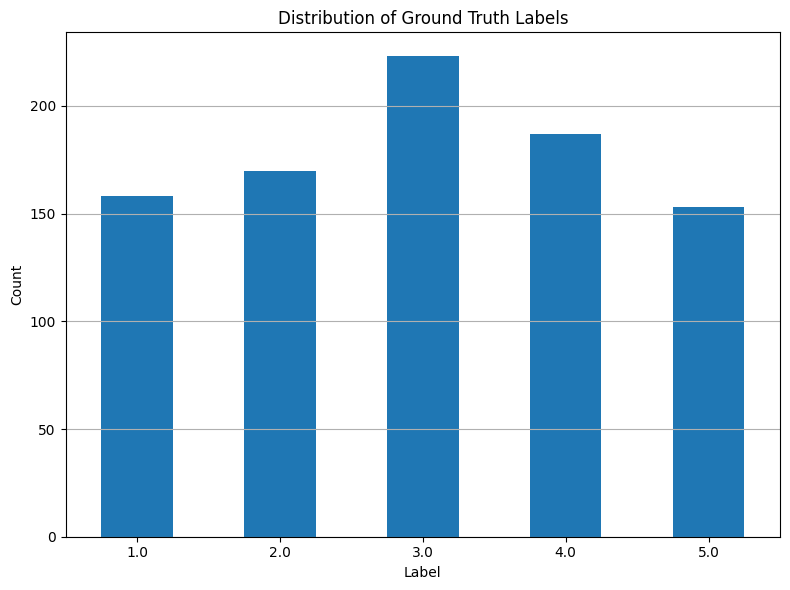

In [12]:
# ground truth
df = pd.read_csv('cleaned_combined.csv')
majority_labels = df.groupby('tweet')['label'].agg(lambda x: x.mode().iloc[0]).reset_index()
majority_labels.columns = ['tweet', 'ground_truth_label']
majority_labels.to_csv('ground_truth_labels.csv', index=False)

# ground truth visualization
labels_df = pd.read_csv('ground_truth_labels.csv')
label_counts = labels_df['ground_truth_label'].value_counts().sort_index()
label_counts.plot(kind='bar', figsize=(8,6), rot=0)

plt.title('Distribution of Ground Truth Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.grid(axis='y')

plt.tight_layout()
plt.savefig('label_distribution.png')
plt.show()